# <span style="color:navy"> Forecasting Air Passenger</span>

In [1]:
import pandas as pd
import numpy as np
import zipfile
import kaggle
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# download the dataset directly from the Kaggle website
!kaggle datasets download -d ashfakyeafi/air-passenger-data-for-time-series-analysis

Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/air-passenger-data-for-time-series-analysis
License(s): CC0-1.0




  0%|          | 0.00/764 [00:00<?, ?B/s]
100%|##########| 764/764 [00:00<?, ?B/s] 


In [4]:
# Name of the zip file
zipfile_name = 'air-passenger-data-for-time-series-analysis.zip'

# Extract the contents of the zip file
with zipfile.ZipFile(zipfile_name, 'r') as file:
    file.extractall()

print("Extraction completed!")

Extraction completed!


In [2]:
# Explore the dataset

airpass = pd.read_csv('AirPassengers.csv')
airpass.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
airpass.tail()

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [4]:
airpass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [5]:
# Convert correctly: %m for month (not %M)
airpass['Month'] = pd.to_datetime(airpass['Month'], format='%Y-%m')

# add Year-Month period column
airpass['Date'] = airpass['Month'].dt.to_period('M')

airpass.head()

,Month,#Passengers,Date
0,1949-01-01,112,1949-01
1,1949-02-01,118,1949-02
2,1949-03-01,132,1949-03
3,1949-04-01,129,1949-04
4,1949-05-01,121,1949-05


In [6]:
airpass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
 2   Date         144 non-null    period[M]     
dtypes: datetime64[ns](1), int64(1), period[M](1)
memory usage: 3.5 KB


In [7]:
#drop the column Month and rename the Passengers column by removing the '#' sign

airpass.rename(columns={'#Passengers':'Passengers'}, inplace= True)
airpass.head() 

airpass.drop('Month', axis=1, inplace=True)

In [8]:
airpass.head()

,Passengers,Date
0,112,1949-01
1,118,1949-02
2,132,1949-03
3,129,1949-04
4,121,1949-05


In [9]:
airpass = airpass.set_index('Date')

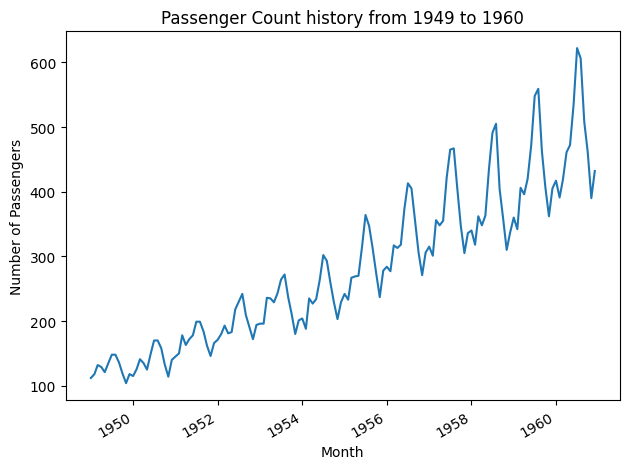

In [10]:
#let's visualize the data
airpass.index = airpass.index.to_timestamp()
fig, ax = plt.subplots()
ax.plot(airpass['Passengers'])
ax.set_xlabel('Month')
ax.set_ylabel('Number of Passengers')
plt.title('Passenger Count history from 1949 to 1960')
fig.autofmt_xdate()
plt.tight_layout()

## Series Decomposition

In [11]:
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

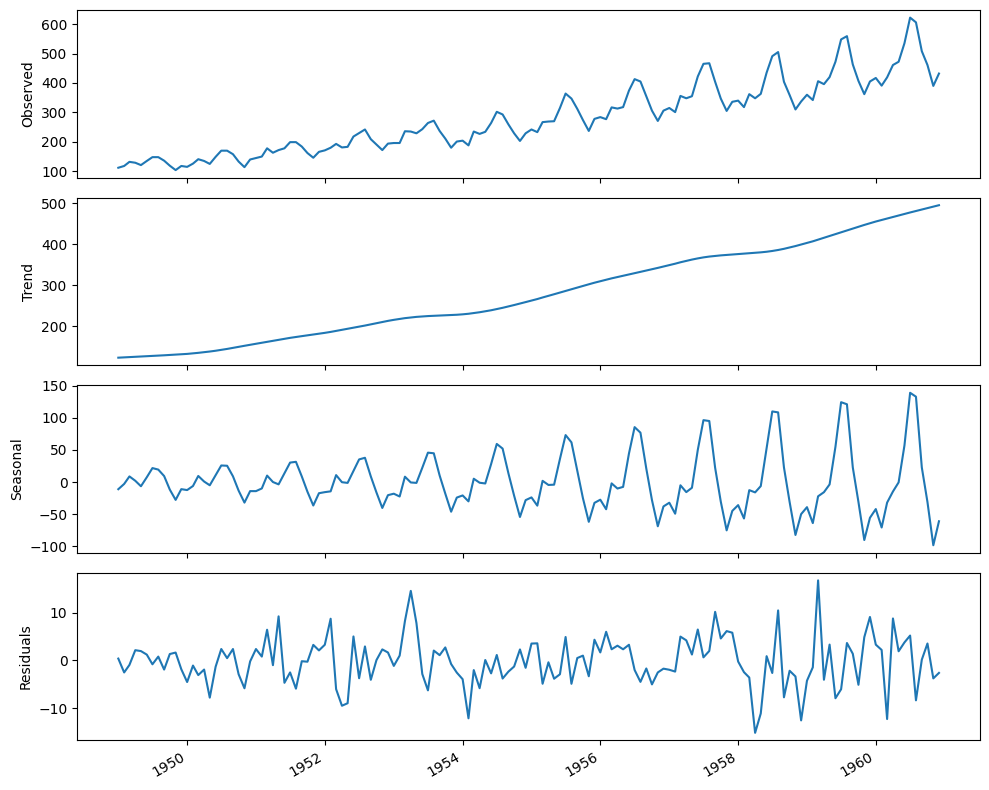

In [12]:
decomposition = STL(airpass['Passengers'], period=12).fit()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

A clear seasonality is observed, hence we are going to forecast using a SARIMA model

## Forecasting using SARIMA

In [13]:
# checking stationarity

adfuller_test = adfuller(airpass['Passengers'])

print(f'The ADF Statistics is: {adfuller_test[0]}')
print(f'The p-value is: {adfuller_test[1]}')

The ADF Statistics is: 0.8153688792060482
The p-value is: 0.991880243437641


In [14]:
# the series is not stationary, requiring some differencing

airpass_diff = np.diff(airpass['Passengers'], n=1)
adfuller_test_diff = adfuller(airpass_diff)

print(f'The ADF Stastistics is :{adfuller_test_diff[0]}')
print(f'p-value is :{adfuller_test_diff[1]}')

The ADF Stastistics is :-2.8292668241699994
p-value is :0.0542132902838255


In [15]:
# still not stationary, we move on with a seasonal differencing as the series shows annual seasonality

airpass_seasonal_diff = airpass['Passengers'].diff(12).dropna()
ad_res = adfuller(airpass_seasonal_diff) 

print(f'THE ADF Statistics is: {ad_res[0]}')
print(f'p-value is: {ad_res[1]}')

THE ADF Statistics is: -3.383020726492481
p-value is: 0.011551493085514954


In [16]:
## Define train and test splits

airpass.shape

(144, 1)

In [17]:
train_size = int(len(airpass) * 0.8)
train = airpass.iloc[:train_size]
test = airpass.iloc[train_size:]
print(f'train size:{train.shape}, test size:{test.shape}')

train size:(115, 1), test size:(29, 1)


In [23]:
first_index = test.index[0]
last_index = test.index[-1]

print(f'first index:{first_index}')
print(f'last index:{last_index}')

first index:1958-08-01 00:00:00
last index:1960-12-01 00:00:00


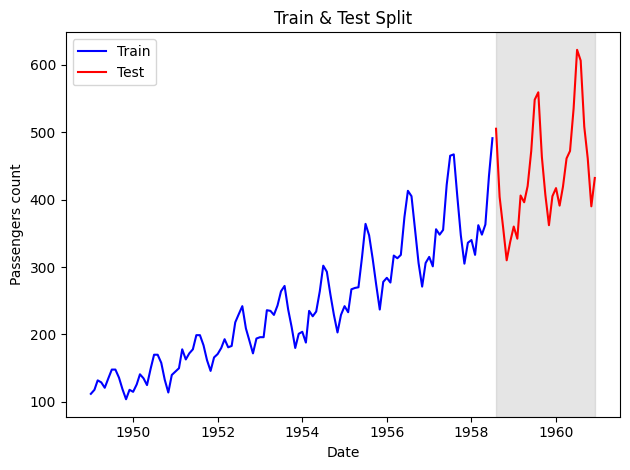

In [24]:
# let's plot tarin and test portions of the data

fig, ax = plt.subplots()
ax.plot(train['Passengers'], 'b', label='Train')
ax.plot(test['Passengers'], 'r', label='Test')
ax.set_xlabel('Date')
ax.set_ylabel('Passengers count')
plt.title('Train & Test Split')
ax.legend(loc='best')
ax.axvspan(first_index, last_index, color='#808080', alpha=0.2)
plt.tight_layout()

## Model Selection using AIC

In [25]:
def SARIMA_gridsearch(endog, min_p, max_p, min_q, max_q, min_P, max_P, min_Q, max_Q, d, D, s):
    
    all_p = range(min_p, max_p+1, 1)
    all_q = range(min_q, max_q+1, 1)
    all_P = range(min_P, max_P+1, 1)
    all_Q = range(min_Q, max_Q+1, 1)
    
    all_orders = list(product(all_p, all_q, all_P, all_Q))
    
    print(f'Fitting {len(all_orders)} unique models')
    
    results = []
    
    for order in tqdm_notebook(all_orders):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s)).fit(disp=False)
        except:
            continue
            
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [30]:
min_p = 0
max_p = 4
min_q = 0
max_q = 4

min_P = 0
max_P = 4
min_Q = 0
max_Q = 4

d = 1
D = 1
s = 12

result_df = SARIMA_gridsearch(train['Passengers'], min_p, max_p, min_q, max_q, min_P, max_P, min_Q, max_Q, d, D, s)
result_df.head()

Fitting 625 unique models


  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(1, 0, 2, 2)",78.078203
1,"(1, 0, 1, 2)",751.148186
2,"(4, 2, 1, 2)",751.232351
3,"(0, 3, 1, 2)",751.424568
4,"(0, 1, 1, 2)",751.727644


In [26]:
sarima_model = SARIMAX(train['Passengers'], order= (1, 1, 0), seasonal_order = (1, 1, 2, 12))
sarima_model_fit = sarima_model.fit(disp=False)

print(sarima_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -370.574
Date:                                 Sat, 04 Oct 2025   AIC                            751.148
Time:                                         10:45:16   BIC                            764.273
Sample:                                     01-01-1949   HQIC                           756.463
                                          - 07-01-1958                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2361      0.093     -2.550      0.011      -0.418      -0

## Residual Analysis

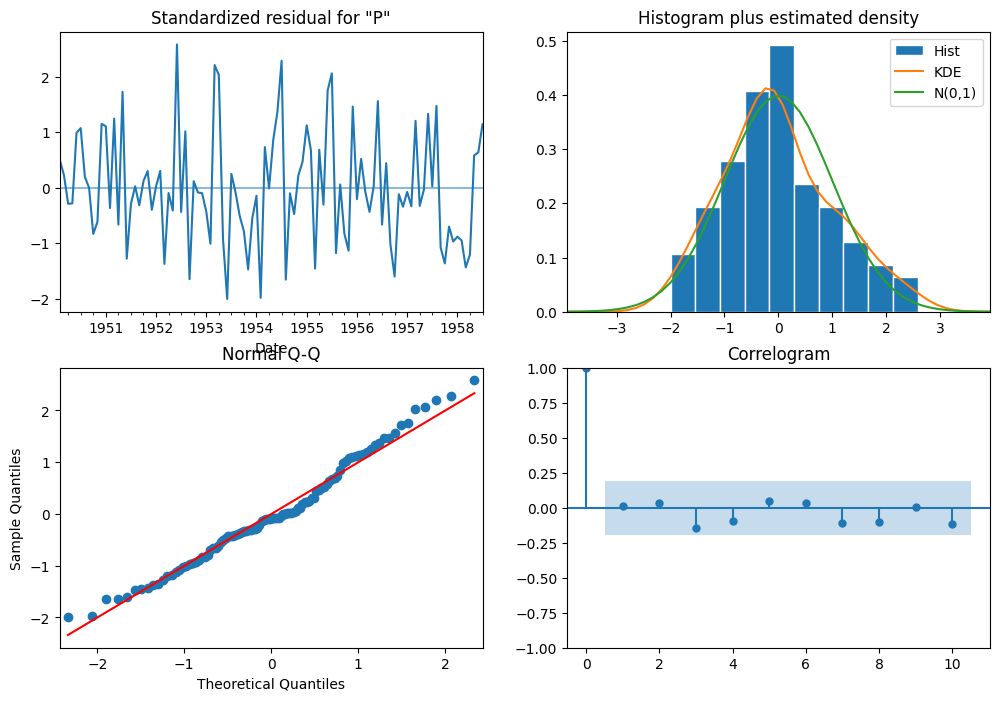

In [27]:
sarima_model_fit.plot_diagnostics(figsize=(12,8))
fig.tight_layout()

The residuals are nearly straight on the Q-Q plot. In addition, the first plot shows no trend. The histogram suggests that the residuals are normally distributed and the correlogram shows no autocorrelation left; therefore, the residuals look like white noise. 

In [28]:
# perform the Ljung Box Statistic test

residuals = sarima_model_fit.resid
lb_test = acorr_ljungbox(residuals, lags=np.arange(1,11,1), return_df=True) 

#Extract p-values
pvalues = lb_test['lb_pvalue']

print(f'p-values are:{pvalues}')

p-values are:1     0.993757
2     0.655489
3     0.801864
4     0.886850
5     0.900017
6     0.942780
7     0.925675
8     0.907620
9     0.928923
10    0.825741
Name: lb_pvalue, dtype: float64


the p values are all above 0.05, Therefore, at each lag, the null hypothesis cannot be rejected, meaning that the residuals are independently distributed and uncorrelated.

## Forescasting

In [29]:
# forecast for the length of the test set

forecast = sarima_model_fit.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

In [30]:
forecast_mean.index = test.index
forecast_conf_int.index = test.index

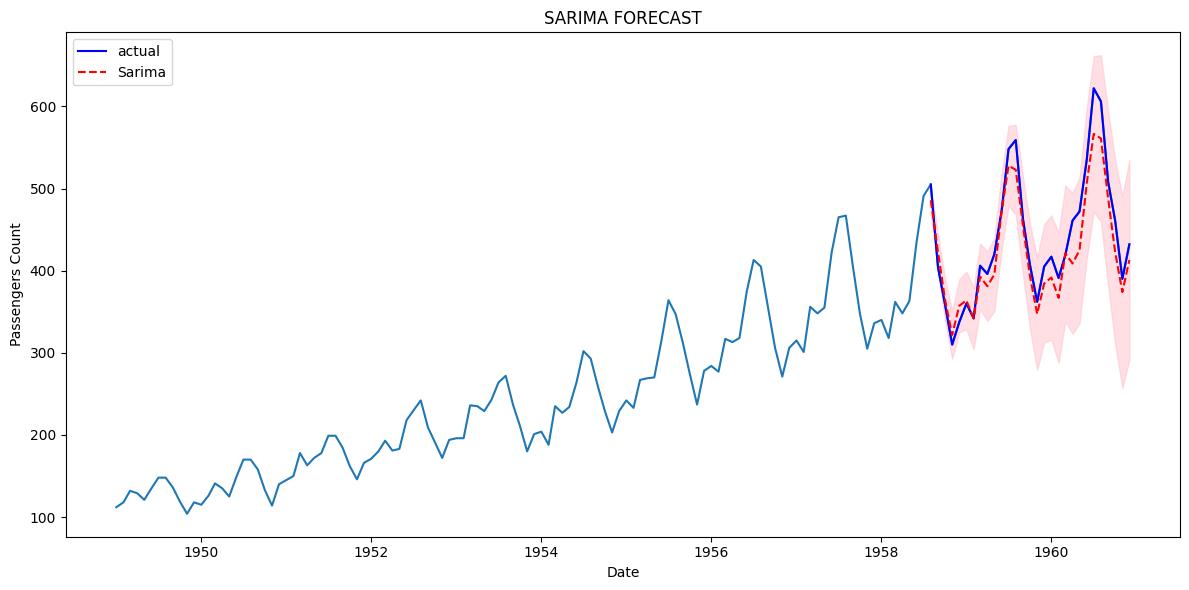

In [31]:
# let's plot actual and forecasted value of the test set

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(airpass['Passengers'])
ax.plot(test['Passengers'], 'b', label='actual')
ax.plot(forecast_mean, 'r--',  label='Sarima')
plt.fill_between(test.index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.5)
ax.legend(loc='best')
plt.title('SARIMA FORECAST')
ax.set_xlabel('Date')
ax.set_ylabel('Passengers Count')
plt.tight_layout()

## Model Evaluation

In [32]:
#Evaluation of the forecast results using the Mean Absolute

mape = np.mean(np.abs((test['Passengers'] - forecast_mean) / test['Passengers'])) * 100
print(f'The MAPE is:{round(mape, 2)}%')

The MAPE is:4.66%


## FORECAST WITH XGBOOST 

In [35]:
# features selection

def create_features(airpass):
    """
    Create time series features based on time series index.
    """
    df = airpass.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(airpass)

## Visualize our Feature / Target Relationship

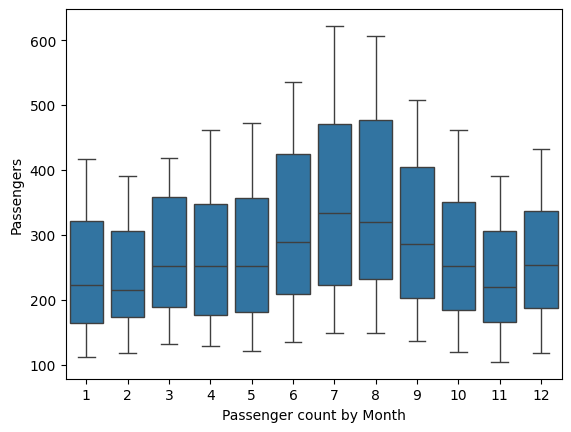

In [36]:
import seaborn as sns

fig, ax =plt.subplots()
sns.boxplot(data=df, x='month', y='Passengers')
ax.set_xlabel('Passenger count by Month')
plt.show()

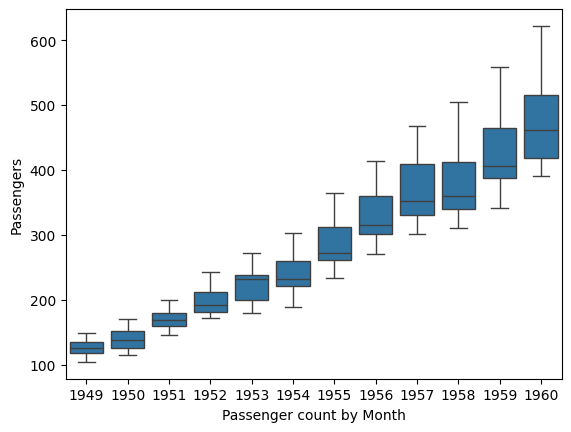

In [37]:
fig, ax =plt.subplots()
sns.boxplot(data=df, x='year', y='Passengers')
ax.set_xlabel('Passenger count by year')
plt.show()

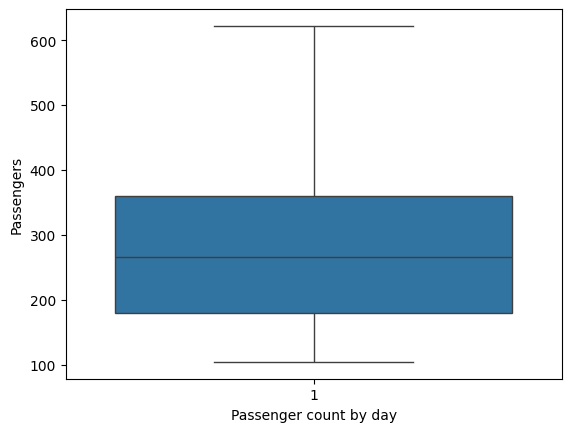

In [39]:
fig, ax =plt.subplots()
sns.boxplot(data=df, x='dayofmonth', y='Passengers')
ax.set_xlabel('Passenger count by day')
plt.show()

## Create the XGBoost model

In [40]:
Train = create_features(train)
Test = create_features(test)

FEATURES = ['quarter', 'month', 'year']
TARGET = 'Passengers'

X_train = Train[FEATURES]
y_train = Train[TARGET]

X_test = Test[FEATURES]
y_test = Test[TARGET]

In [46]:
import xgboost as xgb

reg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0,
    reg_lambda=1,
    gamma=0,
    objective='reg:squarederror',
)

In [47]:
param_grid = {
    "max_depth": [3, 4, 5, 6],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0, 0.1, 0.3, 0.5],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [1, 2, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

In [48]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

grid = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=2,
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits
Best params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}


In [49]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

In [50]:
# evaluation with the Mean Absolute Percentage error

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'The MAPE is:{round(mape, 2)}%')

The MAPE is:12.96%
